# Estimate Pb scavenging rate from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [6]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

##### Functions

In [7]:
def load_data(stn_name, dissolved=False, particulate=False, aluminium=False):
    
    if dissolved:
        dissolved_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
        if stn_name[0:3]=='CAA':
            number = int(stn_name[3])+3
        elif stn_name[0:2]=='CB':
            number = int(stn_name[2])+12
        else:
            number = int(stn_name[2])

        depth_column = 'Depth.'+str(number)

        dPb    = dissolved_data[stn_name][np.isfinite(Pb_data[stn_name])].astype('float')
        ddepth = dissolved_data[depth_column][np.isfinite(Pb_data[stn_name])].astype('float') ## fix: depth index
    
        return np.array(dPb)*1e3, np.array(ddepth)
    
    if particulate:
        particulate_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')
        
        # particulate
        stns   = particulate_data['GEOTR_STN'].astype('str')
        pPb    = particulate_data['Pb (pmol/L)'].where(stns == stn_name).apply(pd.to_numeric, errors='coerce').dropna().astype('float')
        pdep   = particulate_data['CTDPRS (DBAR)'].where(stns == stn_name).dropna().astype('float')
        pdepth = [pdep[i] for i in pPb.index.values]
        
        return np.array(pPb), np.array(pdepth)
    
    if aluminium:
        particulate_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')
        
        # particulate
        stns   = particulate_data['GEOTR_STN'].astype('str')
        pAl    = particulate_data['Al (nmol/L)'].where(stns == stn_name).apply(pd.to_numeric, errors='coerce').dropna().astype('float')
        pdep   = particulate_data['CTDPRS (DBAR)'].where(stns == stn_name).dropna().astype('float')
        pdepth = [pdep[i] for i in pAl.index.values]
        
        return np.array(pAl), np.array(pdepth)        

In [8]:
def pair_samples(dPb, pPb, ddepth, pdepth):
    #------------ compare depths ------------------------------------------------------------
    dPb_match, pPb_match, ddepth_match, pdepth_match = assoc_depth(dPb, pPb, ddepth, pdepth)
    
    ddepth_match = np.array(ddepth_match); pdepth_match = np.array(pdepth_match);
    
    return dPb_match, pPb_match, ddepth_match, pdepth_match

In [9]:
def assoc_depth(obs1, obs2, depth_obs1, depth_obs2):
    
    # find depths that are in common
    OBS1 = np.copy(obs1)
    OBS2 = np.empty_like(depth_obs1)
    depth_OBS2 = np.empty_like(depth_obs1)
    
    i=0
    for depth in depth_obs1:
        min_val  = np.argmin(np.abs(depth_obs2 - depth))
        if np.abs(depth_obs2[min_val] - depth) > 20:
            OBS1[i]           = np.nan
            OBS2[i]           = np.nan
            depth_OBS2[i]     = np.nan
        else:
            OBS2[i]           = obs2[min_val]
            depth_OBS2[i]     = depth_obs2[min_val]
        i+=1
        
    return OBS1, OBS2, depth_obs1, depth_OBS2

##### Calculations

Select a subset of profiles to use for estimate

In [10]:
dPb_CB1, ddepth_CB1 = load_data('CB1', dissolved=True, particulate=False)
dPb_CB2, ddepth_CB2 = load_data('CB2', dissolved=True, particulate=False)
dPb_CB3, ddepth_CB3 = load_data('CB3', dissolved=True, particulate=False)
dPb_CB4, ddepth_CB4 = load_data('CB4', dissolved=True, particulate=False)

dPb_BB1, ddepth_BB1 = load_data('BB1', dissolved=True, particulate=False)
dPb_BB2, ddepth_BB2 = load_data('BB2', dissolved=True, particulate=False)
dPb_BB3, ddepth_BB3 = load_data('BB3', dissolved=True, particulate=False)

dPb_CAA1, ddepth_CAA1 = load_data('CAA1', dissolved=True, particulate=False)
dPb_CAA9, ddepth_CAA9 = load_data('CAA9', dissolved=True, particulate=False)
dPb_CAA3, ddepth_CAA3 = load_data('CAA3', dissolved=True, particulate=False)
dPb_CAA4, ddepth_CAA4 = load_data('CAA4', dissolved=True, particulate=False)
dPb_CAA5, ddepth_CAA5 = load_data('CAA5', dissolved=True, particulate=False)
dPb_CAA6, ddepth_CAA6 = load_data('CAA6', dissolved=True, particulate=False)
dPb_CAA7, ddepth_CAA7 = load_data('CAA7', dissolved=True, particulate=False)
dPb_CAA8, ddepth_CAA8 = load_data('CAA8', dissolved=True, particulate=False)

In [11]:
pPb_CB1, pdepth_CB1 = load_data('CB1', dissolved=False, particulate=True)
pPb_CB2, pdepth_CB2 = load_data('CB2', dissolved=False, particulate=True)
pPb_CB3, pdepth_CB3 = load_data('CB3', dissolved=False, particulate=True)
pPb_CB4, pdepth_CB4 = load_data('CB4', dissolved=False, particulate=True)

pPb_BB1, pdepth_BB1 = load_data('BB1', dissolved=False, particulate=True)
pPb_BB2, pdepth_BB2 = load_data('BB2', dissolved=False, particulate=True)
pPb_BB3, pdepth_BB3 = load_data('BB3', dissolved=False, particulate=True)

pPb_CAA1, pdepth_CAA1 = load_data('CAA1', dissolved=False, particulate=True)
pPb_CAA9, pdepth_CAA9 = load_data('CAA9', dissolved=False, particulate=True)
pPb_CAA3, pdepth_CAA3 = load_data('CAA3', dissolved=False, particulate=True)
pPb_CAA4, pdepth_CAA4 = load_data('CAA4', dissolved=False, particulate=True)
pPb_CAA5, pdepth_CAA5 = load_data('CAA5', dissolved=False, particulate=True)
pPb_CAA6, pdepth_CAA6 = load_data('CAA6', dissolved=False, particulate=True)
pPb_CAA7, pdepth_CAA7 = load_data('CAA7', dissolved=False, particulate=True)
pPb_CAA8, pdepth_CAA8 = load_data('CAA8', dissolved=False, particulate=True)

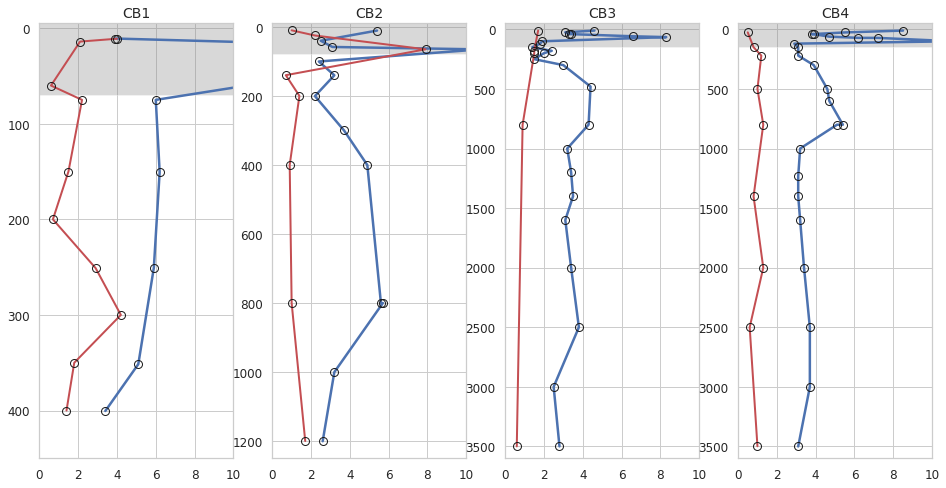

In [9]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,4, figsize=(16,8))
    for axs in ax:
        axs.invert_yaxis()
        axs.set_xlim([0, 10])
        axs.tick_params(axis='both', which='major', labelsize=12)

    ax[0].plot(dPb_CB1[~np.isnan(dPb_CB1)], ddepth_CB1[~np.isnan(dPb_CB1)], '-', linewidth=2.5)
    ax[1].plot(dPb_CB2[~np.isnan(dPb_CB2)], ddepth_CB2[~np.isnan(dPb_CB2)], '-', linewidth=2.5)
    ax[2].plot(dPb_CB3[~np.isnan(dPb_CB3)], ddepth_CB3[~np.isnan(dPb_CB3)], '-', linewidth=2.5)
    ax[3].plot(dPb_CB4[~np.isnan(dPb_CB4)], ddepth_CB4[~np.isnan(dPb_CB4)], '-', linewidth=2.5)

    ax[0].plot(pPb_CB1[~np.isnan(pPb_CB1)], pdepth_CB1[~np.isnan(pPb_CB1)], '-r', linewidth=2.0)
    ax[1].plot(pPb_CB2[~np.isnan(pPb_CB2)], pdepth_CB2[~np.isnan(pPb_CB2)], '-r', linewidth=2.0)
    ax[2].plot(pPb_CB3[~np.isnan(pPb_CB3)], pdepth_CB3[~np.isnan(pPb_CB3)], '-r', linewidth=2.0)
    ax[3].plot(pPb_CB4[~np.isnan(pPb_CB4)], pdepth_CB4[~np.isnan(pPb_CB4)], '-r', linewidth=2.0)

    ax[0].plot(dPb_CB1[~np.isnan(dPb_CB1)], ddepth_CB1[~np.isnan(dPb_CB1)], 'ok', fillstyle='none', markersize=8)
    ax[1].plot(dPb_CB2[~np.isnan(dPb_CB2)], ddepth_CB2[~np.isnan(dPb_CB2)], 'ok', fillstyle='none', markersize=8)
    ax[2].plot(dPb_CB3[~np.isnan(dPb_CB3)], ddepth_CB3[~np.isnan(dPb_CB3)], 'ok', fillstyle='none', markersize=8)
    ax[3].plot(dPb_CB4[~np.isnan(dPb_CB4)], ddepth_CB4[~np.isnan(dPb_CB4)], 'ok', fillstyle='none', markersize=8)

    ax[0].plot(pPb_CB1[~np.isnan(pPb_CB1)], pdepth_CB1[~np.isnan(pPb_CB1)], 'ok', fillstyle='none', markersize=8)
    ax[1].plot(pPb_CB2[~np.isnan(pPb_CB2)], pdepth_CB2[~np.isnan(pPb_CB2)], 'ok', fillstyle='none', markersize=8)
    ax[2].plot(pPb_CB3[~np.isnan(pPb_CB3)], pdepth_CB3[~np.isnan(pPb_CB3)], 'ok', fillstyle='none', markersize=8)
    ax[3].plot(pPb_CB4[~np.isnan(pPb_CB4)], pdepth_CB4[~np.isnan(pPb_CB4)], 'ok', fillstyle='none', markersize=8)

    #grey boxes:
    ax[0].fill_between([-2,20], [-20,-20], [70,70], facecolor='grey', alpha=0.3)
    ax[1].fill_between([-2,20], [-20,-20], [80,80], facecolor='grey', alpha=0.3)
    ax[2].fill_between([-2,20], [-50,-50], [150,150], facecolor='grey', alpha=0.3)
    ax[3].fill_between([-2,20], [-50,-50], [150,150], facecolor='grey', alpha=0.3)

    ax[0].set_ylim([450, -5])
    ax[1].set_ylim([1250,-10])
    ax[2].set_ylim([3600,-50])
    ax[3].set_ylim([3600,-50])

    # ax[3].plot(-1,2, '-r', linewidth=2.5, label='particulate Pb')
    # ax[3].plot(-1,2, '-', linewidth=2.5, label='dissolved Pb')

    ax[0].set_title('CB1', fontsize=14)
    ax[1].set_title('CB2', fontsize=14)
    ax[2].set_title('CB3', fontsize=14)
    ax[3].set_title('CB4', fontsize=14)

    # ax[3].legend(frameon=False, fontsize=14)

    # fig.text(0.5, 0.04, 'Concentration [nM]', ha='center', va='center', fontsize=14)
    # fig.text(0.06, 0.5, 'Depth [m]', ha='center', va='center', rotation='vertical', fontsize=14)

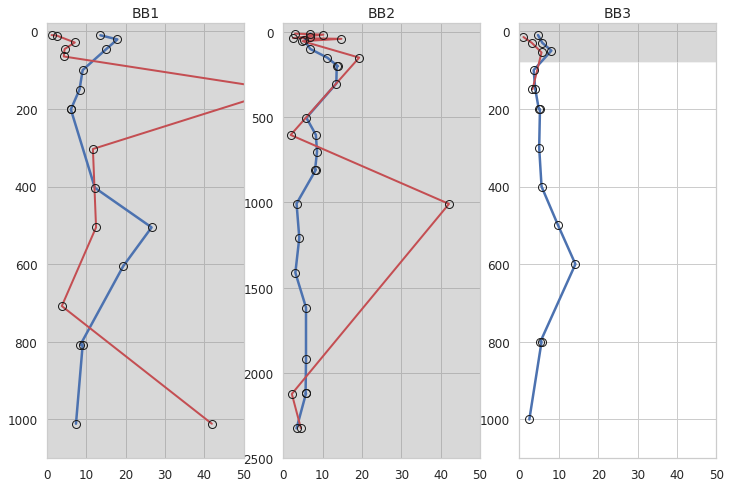

In [10]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,3, figsize=(12,8))
    for axs in ax:
        axs.invert_yaxis()
        axs.set_xlim([0, 50])
        axs.tick_params(axis='both', which='major', labelsize=12)

    ax[0].plot(dPb_BB1[~np.isnan(dPb_BB1)], ddepth_BB1[~np.isnan(dPb_BB1)], '-', linewidth=2.5)
    ax[1].plot(dPb_BB2[~np.isnan(dPb_BB2)], ddepth_BB2[~np.isnan(dPb_BB2)], '-', linewidth=2.5)
    ax[2].plot(dPb_BB3[~np.isnan(dPb_BB3)], ddepth_BB3[~np.isnan(dPb_BB3)], '-', linewidth=2.5)

    ax[0].plot(pPb_BB1[~np.isnan(pPb_BB1)], pdepth_BB1[~np.isnan(pPb_BB1)], '-r', linewidth=2.0)
    ax[1].plot(pPb_BB2[~np.isnan(pPb_BB2)], pdepth_BB2[~np.isnan(pPb_BB2)], '-r', linewidth=2.0)
    ax[2].plot(pPb_BB3[~np.isnan(pPb_BB3)], pdepth_BB3[~np.isnan(pPb_BB3)], '-r', linewidth=2.0)

    ax[0].plot(dPb_BB1[~np.isnan(dPb_BB1)], ddepth_BB1[~np.isnan(dPb_BB1)], 'ok', fillstyle='none', markersize=8)
    ax[1].plot(dPb_BB2[~np.isnan(dPb_BB2)], ddepth_BB2[~np.isnan(dPb_BB2)], 'ok', fillstyle='none', markersize=8)
    ax[2].plot(dPb_BB3[~np.isnan(dPb_BB3)], ddepth_BB3[~np.isnan(dPb_BB3)], 'ok', fillstyle='none', markersize=8)

    ax[0].plot(pPb_BB1[~np.isnan(pPb_BB1)], pdepth_BB1[~np.isnan(pPb_BB1)], 'ok', fillstyle='none', markersize=8)
    ax[1].plot(pPb_BB2[~np.isnan(pPb_BB2)], pdepth_BB2[~np.isnan(pPb_BB2)], 'ok', fillstyle='none', markersize=8)
    ax[2].plot(pPb_BB3[~np.isnan(pPb_BB3)], pdepth_BB3[~np.isnan(pPb_BB3)], 'ok', fillstyle='none', markersize=8)

    # grey boxes:
    ax[0].fill_between([-2,60], [-50,-50], [2000,2000], facecolor='grey', alpha=0.3)
    ax[1].fill_between([-2,60], [-50,-50], [2500,2500], facecolor='grey', alpha=0.3)
    ax[2].fill_between([-2,60], [-50,-50], [80,80], facecolor='grey', alpha=0.3)

    ax[0].set_ylim([1100,-20])
    ax[1].set_ylim([2500,-50])
    ax[2].set_ylim([1100,-20])

    # ax[3].plot(-1,2, '-r', linewidth=2.5, label='particulate Pb')
    # ax[3].plot(-1,2, '-', linewidth=2.5, label='dissolved Pb')

    ax[0].set_title('BB1', fontsize=14)
    ax[1].set_title('BB2', fontsize=14)
    ax[2].set_title('BB3', fontsize=14)

    # ax[3].legend(frameon=False, fontsize=14)

    # fig.text(0.5, 0.04, 'Concentration [nM]', ha='center', va='center', fontsize=14)
    # fig.text(0.06, 0.5, 'Depth [m]', ha='center', va='center', rotation='vertical', fontsize=14)

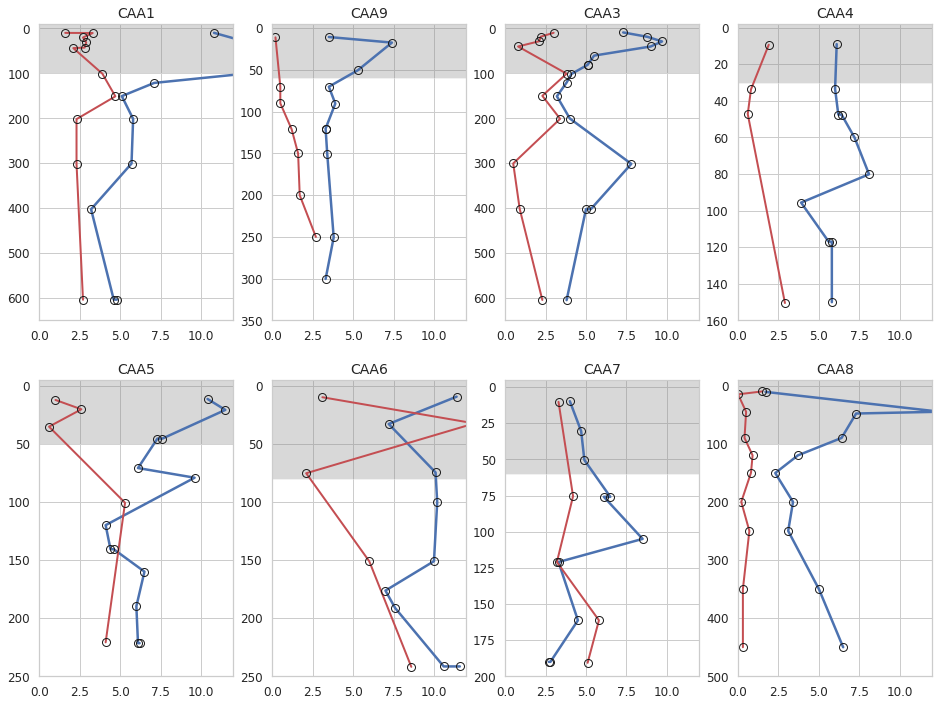

In [11]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(2,4, figsize=(16,12))
    for axs in ax[0,:]:
        axs.invert_yaxis()
        axs.set_xlim([0, 12])
        axs.tick_params(axis='both', which='major', labelsize=12)

    for axs in ax[1,:]:
        axs.invert_yaxis()
        axs.set_xlim([0, 12])
        axs.tick_params(axis='both', which='major', labelsize=12)
    
    ax[0,0].plot(dPb_CAA1[~np.isnan(dPb_CAA1)], ddepth_CAA1[~np.isnan(dPb_CAA1)], '-', linewidth=2.5)
    ax[0,1].plot(dPb_CAA9[~np.isnan(dPb_CAA9)], ddepth_CAA9[~np.isnan(dPb_CAA9)], '-', linewidth=2.5)
    ax[0,2].plot(dPb_CAA3[~np.isnan(dPb_CAA3)], ddepth_CAA3[~np.isnan(dPb_CAA3)], '-', linewidth=2.5)
    ax[0,3].plot(dPb_CAA4[~np.isnan(dPb_CAA4)], ddepth_CAA4[~np.isnan(dPb_CAA4)], '-', linewidth=2.5)
    ax[1,0].plot(dPb_CAA5[~np.isnan(dPb_CAA5)], ddepth_CAA5[~np.isnan(dPb_CAA5)], '-', linewidth=2.5)
    ax[1,1].plot(dPb_CAA6[~np.isnan(dPb_CAA6)], ddepth_CAA6[~np.isnan(dPb_CAA6)], '-', linewidth=2.5)
    ax[1,2].plot(dPb_CAA7[~np.isnan(dPb_CAA7)], ddepth_CAA7[~np.isnan(dPb_CAA7)], '-', linewidth=2.5)
    ax[1,3].plot(dPb_CAA8[~np.isnan(dPb_CAA8)], ddepth_CAA8[~np.isnan(dPb_CAA8)], '-', linewidth=2.5)

    ax[0,0].plot(pPb_CAA1[~np.isnan(pPb_CAA1)], pdepth_CAA1[~np.isnan(pPb_CAA1)], '-r', linewidth=2.0)
    ax[0,1].plot(pPb_CAA9[~np.isnan(pPb_CAA9)], pdepth_CAA9[~np.isnan(pPb_CAA9)], '-r', linewidth=2.0)
    ax[0,2].plot(pPb_CAA3[~np.isnan(pPb_CAA3)], pdepth_CAA3[~np.isnan(pPb_CAA3)], '-r', linewidth=2.0)
    ax[0,3].plot(pPb_CAA4[~np.isnan(pPb_CAA4)], pdepth_CAA4[~np.isnan(pPb_CAA4)], '-r', linewidth=2.0)
    ax[1,0].plot(pPb_CAA5[~np.isnan(pPb_CAA5)], pdepth_CAA5[~np.isnan(pPb_CAA5)], '-r', linewidth=2.0)
    ax[1,1].plot(pPb_CAA6[~np.isnan(pPb_CAA6)], pdepth_CAA6[~np.isnan(pPb_CAA6)], '-r', linewidth=2.0)
    ax[1,2].plot(pPb_CAA7[~np.isnan(pPb_CAA7)], pdepth_CAA7[~np.isnan(pPb_CAA7)], '-r', linewidth=2.0)
    ax[1,3].plot(pPb_CAA8[~np.isnan(pPb_CAA8)], pdepth_CAA8[~np.isnan(pPb_CAA8)], '-r', linewidth=2.0)

    ax[0,0].plot(dPb_CAA1[~np.isnan(dPb_CAA1)], ddepth_CAA1[~np.isnan(dPb_CAA1)], 'ok', fillstyle='none', markersize=8)
    ax[0,1].plot(dPb_CAA9[~np.isnan(dPb_CAA9)], ddepth_CAA9[~np.isnan(dPb_CAA9)], 'ok', fillstyle='none', markersize=8)
    ax[0,2].plot(dPb_CAA3[~np.isnan(dPb_CAA3)], ddepth_CAA3[~np.isnan(dPb_CAA3)], 'ok', fillstyle='none', markersize=8)
    ax[0,3].plot(dPb_CAA4[~np.isnan(dPb_CAA4)], ddepth_CAA4[~np.isnan(dPb_CAA4)], 'ok', fillstyle='none', markersize=8)
    ax[1,0].plot(dPb_CAA5[~np.isnan(dPb_CAA5)], ddepth_CAA5[~np.isnan(dPb_CAA5)], 'ok', fillstyle='none', markersize=8)
    ax[1,1].plot(dPb_CAA6[~np.isnan(dPb_CAA6)], ddepth_CAA6[~np.isnan(dPb_CAA6)], 'ok', fillstyle='none', markersize=8)
    ax[1,2].plot(dPb_CAA7[~np.isnan(dPb_CAA7)], ddepth_CAA7[~np.isnan(dPb_CAA7)], 'ok', fillstyle='none', markersize=8)
    ax[1,3].plot(dPb_CAA8[~np.isnan(dPb_CAA8)], ddepth_CAA8[~np.isnan(dPb_CAA8)], 'ok', fillstyle='none', markersize=8)

    ax[0,0].plot(pPb_CAA1[~np.isnan(pPb_CAA1)], pdepth_CAA1[~np.isnan(pPb_CAA1)], 'ok', fillstyle='none', markersize=8)
    ax[0,1].plot(pPb_CAA9[~np.isnan(pPb_CAA9)], pdepth_CAA9[~np.isnan(pPb_CAA9)], 'ok', fillstyle='none', markersize=8)
    ax[0,2].plot(pPb_CAA3[~np.isnan(pPb_CAA3)], pdepth_CAA3[~np.isnan(pPb_CAA3)], 'ok', fillstyle='none', markersize=8)
    ax[0,3].plot(pPb_CAA4[~np.isnan(pPb_CAA4)], pdepth_CAA4[~np.isnan(pPb_CAA4)], 'ok', fillstyle='none', markersize=8)
    ax[1,0].plot(pPb_CAA5[~np.isnan(pPb_CAA5)], pdepth_CAA5[~np.isnan(pPb_CAA5)], 'ok', fillstyle='none', markersize=8)
    ax[1,1].plot(pPb_CAA6[~np.isnan(pPb_CAA6)], pdepth_CAA6[~np.isnan(pPb_CAA6)], 'ok', fillstyle='none', markersize=8)
    ax[1,2].plot(pPb_CAA7[~np.isnan(pPb_CAA7)], pdepth_CAA7[~np.isnan(pPb_CAA7)], 'ok', fillstyle='none', markersize=8)
    ax[1,3].plot(pPb_CAA8[~np.isnan(pPb_CAA8)], pdepth_CAA8[~np.isnan(pPb_CAA8)], 'ok', fillstyle='none', markersize=8)

    #grey boxes:
    ax[0,0].fill_between([-2,20], [-20,-20], [100,100], facecolor='grey', alpha=0.3)
    ax[0,1].fill_between([-2,20], [-20,-20], [60,60], facecolor='grey', alpha=0.3)
    ax[0,2].fill_between([-2,20], [-20,-20], [100,100], facecolor='grey', alpha=0.3)
    ax[0,3].fill_between([-2,20], [-20,-20], [30,30], facecolor='grey', alpha=0.3)
    ax[1,0].fill_between([-2,20], [-20,-20], [50,50], facecolor='grey', alpha=0.3)
    ax[1,1].fill_between([-2,20], [-20,-20], [80,80], facecolor='grey', alpha=0.3)
    ax[1,2].fill_between([-2,20], [-20,-20], [60,60], facecolor='grey', alpha=0.3)
    ax[1,3].fill_between([-2,20], [-20,-20], [100,100], facecolor='grey', alpha=0.3)

    ax[0,0].set_ylim([650,-10])
    ax[0,1].set_ylim([350,-5])
    ax[0,2].set_ylim([650,-10])
    ax[0,3].set_ylim([160,-2])
    ax[1,0].set_ylim([250,-5])
    ax[1,1].set_ylim([250,-5])
    ax[1,2].set_ylim([200,-5])
    ax[1,3].set_ylim([500,-10])

    ax[0,0].set_title('CAA1', fontsize=14)
    ax[0,1].set_title('CAA9', fontsize=14)
    ax[0,2].set_title('CAA3', fontsize=14)
    ax[0,3].set_title('CAA4', fontsize=14)
    ax[1,0].set_title('CAA5', fontsize=14)
    ax[1,1].set_title('CAA6', fontsize=14)
    ax[1,2].set_title('CAA7', fontsize=14)
    ax[1,3].set_title('CAA8', fontsize=14)

In [12]:
# Points to use:
dPb_CB1_use = np.copy(dPb_CB1); pPb_CB1_use = np.copy(pPb_CB1);
dPb_CB2_use = np.copy(dPb_CB2); pPb_CB2_use = np.copy(pPb_CB2);
dPb_CB3_use = np.copy(dPb_CB3); pPb_CB3_use = np.copy(pPb_CB3);
dPb_CB4_use = np.copy(dPb_CB4); pPb_CB4_use = np.copy(pPb_CB4);
dPb_BB3_use = np.copy(dPb_BB3); pPb_BB3_use = np.copy(pPb_BB3);
dPb_CAA1_use = np.copy(dPb_CAA1); pPb_CAA1_use = np.copy(pPb_CAA1);
dPb_CAA3_use = np.copy(dPb_CAA3); pPb_CAA3_use = np.copy(pPb_CAA3);
dPb_CAA4_use = np.copy(dPb_CAA4); pPb_CAA4_use = np.copy(pPb_CAA4);
dPb_CAA5_use = np.copy(dPb_CAA5); pPb_CAA5_use = np.copy(pPb_CAA5);
dPb_CAA6_use = np.copy(dPb_CAA6); pPb_CAA6_use = np.copy(pPb_CAA6);
dPb_CAA7_use = np.copy(dPb_CAA7); pPb_CAA7_use = np.copy(pPb_CAA7);
dPb_CAA8_use = np.copy(dPb_CAA8); pPb_CAA8_use = np.copy(pPb_CAA8);
dPb_CAA9_use = np.copy(dPb_CAA9); pPb_CAA9_use = np.copy(pPb_CAA9);

dPb_CB1_use[ddepth_CB1 < 70]    = np.nan; pPb_CB1_use[pdepth_CB1 < 70]    = np.nan;
dPb_CB2_use[ddepth_CB2 < 80]    = np.nan; pPb_CB2_use[pdepth_CB2 < 80]    = np.nan;
dPb_CB3_use[ddepth_CB3 < 150]   = np.nan; pPb_CB3_use[pdepth_CB3 < 150]   = np.nan;
dPb_CB4_use[ddepth_CB4 < 150]   = np.nan; pPb_CB4_use[pdepth_CB4 < 150]   = np.nan;
dPb_BB3_use[ddepth_BB3 < 80]    = np.nan; pPb_BB3_use[pdepth_BB3 < 80]    = np.nan;
dPb_CAA1_use[ddepth_CAA1 < 100] = np.nan; pPb_CAA1_use[pdepth_CAA1 < 100] = np.nan;
dPb_CAA3_use[ddepth_CAA3 < 100] = np.nan; pPb_CAA3_use[pdepth_CAA3 < 100] = np.nan;
dPb_CAA4_use[ddepth_CAA4 < 30]  = np.nan; pPb_CAA4_use[pdepth_CAA4 < 30]  = np.nan;
dPb_CAA5_use[ddepth_CAA5 < 50]  = np.nan; pPb_CAA5_use[pdepth_CAA5 < 50]  = np.nan;
dPb_CAA6_use[ddepth_CAA6 < 80]  = np.nan; pPb_CAA6_use[pdepth_CAA6 < 80]  = np.nan;
dPb_CAA7_use[ddepth_CAA7 < 60]  = np.nan; pPb_CAA7_use[pdepth_CAA7 < 60]  = np.nan;
dPb_CAA8_use[ddepth_CAA8 < 100] = np.nan; pPb_CAA8_use[pdepth_CAA8 < 100] = np.nan;
dPb_CAA9_use[ddepth_CAA9 < 60]  = np.nan; pPb_CAA9_use[pdepth_CAA9 < 60]  = np.nan;

In [13]:
dPb_CB1_mch, pPb_CB1_mch, ddepths_CB1_mch, pdepths_CB1_mch = pair_samples(dPb_CB1_use, pPb_CB1_use, \
                                                                                  ddepth_CB1, pdepth_CB1)
dPb_CB2_mch, pPb_CB2_mch, ddepths_CB2_mch, pdepths_CB2_mch = pair_samples(dPb_CB2_use, pPb_CB2_use, \
                                                                                  ddepth_CB2, pdepth_CB2)
dPb_CB3_mch, pPb_CB3_mch, ddepths_CB3_mch, pdepths_CB3_mch = pair_samples(dPb_CB3_use, pPb_CB3_use, \
                                                                                  ddepth_CB3, pdepth_CB3)
dPb_CB4_mch, pPb_CB4_mch, ddepths_CB4_mch, pdepths_CB4_mch = pair_samples(dPb_CB4_use, pPb_CB4_use, \
                                                                                  ddepth_CB4, pdepth_CB4)

dPb_BB3_mch, pPb_BB3_mch, ddepths_BB3_mch, pdepths_BB3_mch = pair_samples(dPb_BB3_use, pPb_BB3_use, \
                                                                                  ddepth_BB3, pdepth_BB3)

dPb_CAA1_mch, pPb_CAA1_mch, ddepths_CAA1_mch, pdepths_CAA1_mch = pair_samples(dPb_CAA1_use, pPb_CAA1_use, \
                                                                                  ddepth_CAA1, pdepth_CAA1)
dPb_CAA3_mch, pPb_CAA3_mch, ddepths_CAA3_mch, pdepths_CAA3_mch = pair_samples(dPb_CAA3_use, pPb_CAA3_use, \
                                                                                  ddepth_CAA3, pdepth_CAA3)
dPb_CAA4_mch, pPb_CAA4_mch, ddepths_CAA4_mch, pdepths_CAA4_mch = pair_samples(dPb_CAA4_use, pPb_CAA4_use, \
                                                                                  ddepth_CAA4, pdepth_CAA4)
dPb_CAA5_mch, pPb_CAA5_mch, ddepths_CAA5_mch, pdepths_CAA5_mch = pair_samples(dPb_CAA5_use, pPb_CAA5_use, \
                                                                                  ddepth_CAA5, pdepth_CAA5)
dPb_CAA6_mch, pPb_CAA6_mch, ddepths_CAA6_mch, pdepths_CAA6_mch = pair_samples(dPb_CAA6_use, pPb_CAA6_use, \
                                                                                  ddepth_CAA6, pdepth_CAA6)
dPb_CAA7_mch, pPb_CAA7_mch, ddepths_CAA7_mch, pdepths_CAA7_mch = pair_samples(dPb_CAA7_use, pPb_CAA7_use, \
                                                                                  ddepth_CAA7, pdepth_CAA7)
dPb_CAA8_mch, pPb_CAA8_mch, ddepths_CAA8_mch, pdepths_CAA8_mch = pair_samples(dPb_CAA8_use, pPb_CAA8_use, \
                                                                                  ddepth_CAA8, pdepth_CAA8)
dPb_CAA9_mch, pPb_CAA9_mch, ddepths_CAA9_mch, pdepths_CAA9_mch = pair_samples(dPb_CAA9_use, pPb_CAA9_use, \
                                                                                  ddepth_CAA9, pdepth_CAA9)

##### Scavenging relation: dPb vs. pPb

If we assume that the profiles selected are far enough away from sources of particulate Pb, the system is more or less in steady state. In that case, 

$$ \frac{\partial pPb}{\partial t} = k_{ads} \cdot [dPb] - w_{sink} \cdot [pPb] = 0$$

Which simplifies to:
$$ k_{ads} \cdot [dPb] = w_{sink} \cdot [pPb]$$
$$ \rightarrow \frac{[pPb]}{[dPb]} = \frac{k_{ads}}{w_{sink}} $$

In [14]:
cmap_CB  = sns.color_palette("Blues", 4)
cmap_BB  = sns.color_palette("Reds", 1)
cmap_CAA = sns.color_palette("BrBG", 8)   

stn_colors = cmap_CB + cmap_CAA + cmap_BB 

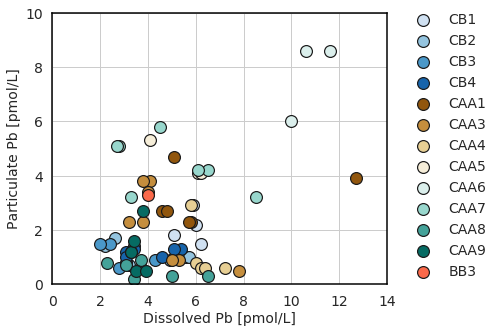

In [16]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    sns.scatterplot(dPb_CB1_mch, pPb_CB1_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(dPb_CB2_mch, pPb_CB2_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(dPb_CB3_mch, pPb_CB3_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(dPb_CB4_mch, pPb_CB4_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(dPb_CAA1_mch, pPb_CAA1_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(dPb_CAA3_mch, pPb_CAA3_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(dPb_CAA4_mch, pPb_CAA4_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(dPb_CAA5_mch, pPb_CAA5_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(dPb_CAA6_mch, pPb_CAA6_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(dPb_CAA7_mch, pPb_CAA7_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(dPb_CAA8_mch, pPb_CAA8_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
    sns.scatterplot(dPb_CAA9_mch, pPb_CAA9_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[11], label='CAA9')
        
    sns.scatterplot(dPb_BB3_mch, pPb_BB3_mch, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.0), fontsize=14, frameon=False)
    ax.set_ylabel('Particulate Pb [pmol/L]', fontsize=14)
    ax.set_xlabel('Dissolved Pb [pmol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,14])
    ax.set_ylim([0,10])
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

##### Scavenging relation alternative: POC 

Let's instead try to carefully select which profiles to use for estimating the relationship based on POC

In [15]:
POCdata  = pd.read_csv('/ocean/brogalla/GEOTRACES/data/POC&PON_Data_GN02-GN03.csv')
POC_data = POCdata.replace(r'< LOD', 0)

In [16]:
POC_BB3 = POC_data['BB3'][1:].dropna().values.astype('float')
POC_CB1 = POC_data['CB1'][1:].dropna().values.astype('float')
POC_CB2 = POC_data['CB2'][1:].dropna().values.astype('float')
POC_CB3 = POC_data['CB3'][1:].dropna().values.astype('float')
POC_CB4 = POC_data['CB4'][1:].dropna().values.astype('float')
POC_CAA1 = POC_data['CAA1'][1:].dropna().values.astype('float')
POC_CAA3 = POC_data['CAA3'][1:].dropna().values.astype('float')
POC_CAA4 = POC_data['CAA4'][1:].dropna().values.astype('float')
POC_CAA5 = POC_data['CAA5'][1:].dropna().values.astype('float')
POC_CAA6 = POC_data['CAA6'][1:].dropna().values.astype('float')
POC_CAA7 = POC_data['CAA7'][1:].dropna().values.astype('float')
POC_CAA8 = POC_data['CAA8'][1:].dropna().values.astype('float')

POC_depth_BB3 = POC_data['Depth.4'][1:].dropna().values.astype('float')
POC_depth_CB1 = POC_data['Depth.12'][1:].dropna().values.astype('float')
POC_depth_CB2 = POC_data['Depth.13'][1:].dropna().values.astype('float')
POC_depth_CB3 = POC_data['Depth.14'][1:].dropna().values.astype('float')
POC_depth_CB4 = POC_data['Depth.15'][1:].dropna().values.astype('float')
POC_depth_CAA1 = POC_data['Depth.5'][1:].dropna().values.astype('float')
POC_depth_CAA3 = POC_data['Depth.6'][1:].dropna().values.astype('float')
POC_depth_CAA4 = POC_data['Depth.7'][1:].dropna().values.astype('float')
POC_depth_CAA5 = POC_data['Depth.8'][1:].dropna().values.astype('float')
POC_depth_CAA6 = POC_data['Depth.9'][1:].dropna().values.astype('float')
POC_depth_CAA7 = POC_data['Depth.10'][1:].dropna().values.astype('float')
POC_depth_CAA8 = POC_data['Depth.11'][1:].dropna().values.astype('float')

In [17]:
dPb_CB1_md, POC_CB1_md, ddepths_CB1_md, POCdepths_CB1_md = pair_samples(dPb_CB1_use, POC_CB1, ddepth_CB1, POC_depth_CB1)
dPb_CB2_md, POC_CB2_md, ddepths_CB2_md, POCdepths_CB2_md = pair_samples(dPb_CB2_use, POC_CB2, ddepth_CB2, POC_depth_CB2)
dPb_CB3_md, POC_CB3_md, ddepths_CB3_md, POCdepths_CB3_md = pair_samples(dPb_CB3_use, POC_CB3, ddepth_CB3, POC_depth_CB3)
dPb_CB4_md, POC_CB4_md, ddepths_CB4_md, POCdepths_CB4_md = pair_samples(dPb_CB4_use, POC_CB4, ddepth_CB4, POC_depth_CB4)
dPb_BB3_md, POC_BB3_md, ddepths_BB3_md, POCdepths_BB3_md = pair_samples(dPb_BB3_use, POC_BB3, ddepth_BB3, POC_depth_BB3)

dPb_CAA1_md, POC_CAA1_md, ddepths_CAA1_md, POCdepths_CAA1_md = pair_samples(dPb_CAA1_use, POC_CAA1, ddepth_CAA1, POC_depth_CAA1)
dPb_CAA3_md, POC_CAA3_md, ddepths_CAA3_md, POCdepths_CAA3_md = pair_samples(dPb_CAA3_use, POC_CAA3, ddepth_CAA3, POC_depth_CAA3)
dPb_CAA4_md, POC_CAA4_md, ddepths_CAA4_md, POCdepths_CAA4_md = pair_samples(dPb_CAA4_use, POC_CAA4, ddepth_CAA4, POC_depth_CAA4)
dPb_CAA5_md, POC_CAA5_md, ddepths_CAA5_md, POCdepths_CAA5_md = pair_samples(dPb_CAA5_use, POC_CAA5, ddepth_CAA5, POC_depth_CAA5)
dPb_CAA6_md, POC_CAA6_md, ddepths_CAA6_md, POCdepths_CAA6_md = pair_samples(dPb_CAA6_use, POC_CAA6, ddepth_CAA6, POC_depth_CAA6)
dPb_CAA7_md, POC_CAA7_md, ddepths_CAA7_md, POCdepths_CAA7_md = pair_samples(dPb_CAA7_use, POC_CAA7, ddepth_CAA7, POC_depth_CAA7)
dPb_CAA8_md, POC_CAA8_md, ddepths_CAA8_md, POCdepths_CAA8_md = pair_samples(dPb_CAA8_use, POC_CAA8, ddepth_CAA8, POC_depth_CAA8)

In [18]:
pPb_CB1_mp, POC_CB1_mp, pdepths_CB1_mp, POCdepths_CB1_mp = pair_samples(pPb_CB1_use, POC_CB1, pdepth_CB1, POC_depth_CB1)
pPb_CB2_mp, POC_CB2_mp, pdepths_CB2_mp, POCdepths_CB2_mp = pair_samples(pPb_CB2_use, POC_CB2, pdepth_CB2, POC_depth_CB2)
pPb_CB3_mp, POC_CB3_mp, pdepths_CB3_mp, POCdepths_CB3_mp = pair_samples(pPb_CB3_use, POC_CB3, pdepth_CB3, POC_depth_CB3)
pPb_CB4_mp, POC_CB4_mp, pdepths_CB4_mp, POCdepths_CB4_mp = pair_samples(pPb_CB4_use, POC_CB4, pdepth_CB4, POC_depth_CB4)
pPb_BB3_mp, POC_BB3_mp, pdepths_BB3_mp, POCdepths_BB3_mp = pair_samples(pPb_BB3_use, POC_BB3, pdepth_BB3, POC_depth_BB3)

pPb_CAA1_mp, POC_CAA1_mp, pdepths_CAA1_mp, POCdepths_CAA1_mp = pair_samples(pPb_CAA1_use, POC_CAA1, pdepth_CAA1, POC_depth_CAA1)
pPb_CAA3_mp, POC_CAA3_mp, pdepths_CAA3_mp, POCdepths_CAA3_mp = pair_samples(pPb_CAA3_use, POC_CAA3, pdepth_CAA3, POC_depth_CAA3)
pPb_CAA4_mp, POC_CAA4_mp, pdepths_CAA4_mp, POCdepths_CAA4_mp = pair_samples(pPb_CAA4_use, POC_CAA4, pdepth_CAA4, POC_depth_CAA4)
pPb_CAA5_mp, POC_CAA5_mp, pdepths_CAA5_mp, POCdepths_CAA5_mp = pair_samples(pPb_CAA5_use, POC_CAA5, pdepth_CAA5, POC_depth_CAA5)
pPb_CAA6_mp, POC_CAA6_mp, pdepths_CAA6_mp, POCdepths_CAA6_mp = pair_samples(pPb_CAA6_use, POC_CAA6, pdepth_CAA6, POC_depth_CAA6)
pPb_CAA7_mp, POC_CAA7_mp, pdepths_CAA7_mp, POCdepths_CAA7_mp = pair_samples(pPb_CAA7_use, POC_CAA7, pdepth_CAA7, POC_depth_CAA7)
pPb_CAA8_mp, POC_CAA8_mp, pdepths_CAA8_mp, POCdepths_CAA8_mp = pair_samples(pPb_CAA8_use, POC_CAA8, pdepth_CAA8, POC_depth_CAA8)

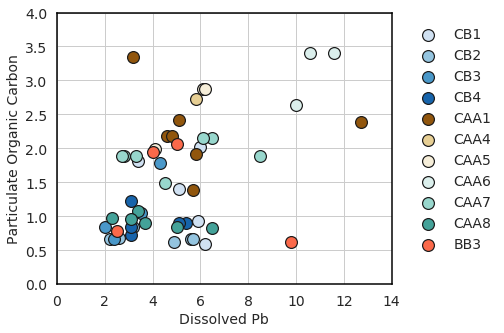

In [21]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    sns.scatterplot(dPb_CB1_md, POC_CB1_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(dPb_CB2_md, POC_CB2_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(dPb_CB3_md, POC_CB3_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(dPb_CB4_md, POC_CB4_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(dPb_CAA1_md, POC_CAA1_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(dPb_CAA3_md, POC_CAA3_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(dPb_CAA4_md, POC_CAA4_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(dPb_CAA5_md, POC_CAA5_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(dPb_CAA6_md, POC_CAA6_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(dPb_CAA7_md, POC_CAA7_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(dPb_CAA8_md, POC_CAA8_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
        
    sns.scatterplot(dPb_BB3_md, POC_BB3_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Particulate Organic Carbon', fontsize=14)
    ax.set_xlabel('Dissolved Pb', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,14])
    ax.set_ylim([0,4])
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

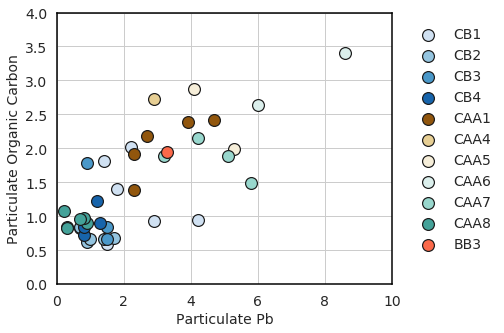

In [22]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    sns.scatterplot(pPb_CB1_mp, POC_CB1_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(pPb_CB2_mp, POC_CB2_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(pPb_CB3_mp, POC_CB3_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(pPb_CB4_mp, POC_CB4_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(pPb_CAA1_mp, POC_CAA1_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(pPb_CAA3_mp, POC_CAA3_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(pPb_CAA4_mp, POC_CAA4_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(pPb_CAA5_mp, POC_CAA5_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(pPb_CAA6_mp, POC_CAA6_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(pPb_CAA7_mp, POC_CAA7_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(pPb_CAA8_mp, POC_CAA8_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
        
    sns.scatterplot(pPb_BB3_mp, POC_BB3_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Particulate Organic Carbon', fontsize=14)
    ax.set_xlabel('Particulate Pb', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,10])
    ax.set_ylim([0,4])
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

In [19]:
ratio_CB1 = pPb_CB1_mch / dPb_CB1_mch
ratio_CB2 = pPb_CB2_mch / dPb_CB2_mch
ratio_CB3 = pPb_CB3_mch / dPb_CB3_mch
ratio_CB4 = pPb_CB4_mch / dPb_CB4_mch

ratio_BB3 = pPb_BB3_mch / dPb_BB3_mch

ratio_CAA1 = pPb_CAA1_mch / dPb_CAA1_mch
ratio_CAA3 = pPb_CAA3_mch / dPb_CAA3_mch
ratio_CAA4 = pPb_CAA4_mch / dPb_CAA4_mch
ratio_CAA5 = pPb_CAA5_mch / dPb_CAA5_mch
ratio_CAA6 = pPb_CAA6_mch / dPb_CAA6_mch
ratio_CAA7 = pPb_CAA7_mch / dPb_CAA7_mch
ratio_CAA8 = pPb_CAA8_mch / dPb_CAA8_mch
ratio_CAA9 = pPb_CAA9_mch / dPb_CAA9_mch

In [20]:
ratio_CB1_m, POC_CB1_m, ddepths_CB1_m, POCdepths_CB1_m = pair_samples(ratio_CB1, POC_CB1, ddepths_CB1_mch, POC_depth_CB1)
ratio_CB2_m, POC_CB2_m, ddepths_CB2_m, POCdepths_CB2_m = pair_samples(ratio_CB2, POC_CB2, ddepths_CB2_mch, POC_depth_CB2)
ratio_CB3_m, POC_CB3_m, ddepths_CB3_m, POCdepths_CB3_m = pair_samples(ratio_CB3, POC_CB3, ddepths_CB3_mch, POC_depth_CB3)
ratio_CB4_m, POC_CB4_m, ddepths_CB4_m, POCdepths_CB4_m = pair_samples(ratio_CB4, POC_CB4, ddepths_CB4_mch, POC_depth_CB4)
ratio_BB3_m, POC_BB3_m, ddepths_BB3_m, POCdepths_BB3_m = pair_samples(ratio_BB3, POC_BB3, ddepths_BB3_mch, POC_depth_BB3)

ratio_CAA1_m, POC_CAA1_m, ddepths_CAA1_m, POCdepths_CAA1_m = pair_samples(ratio_CAA1, POC_CAA1, ddepths_CAA1_mch, POC_depth_CAA1)
ratio_CAA3_m, POC_CAA3_m, ddepths_CAA3_m, POCdepths_CAA3_m = pair_samples(ratio_CAA3, POC_CAA3, ddepths_CAA3_mch, POC_depth_CAA3)
ratio_CAA4_m, POC_CAA4_m, ddepths_CAA4_m, POCdepths_CAA4_m = pair_samples(ratio_CAA4, POC_CAA4, ddepths_CAA4_mch, POC_depth_CAA4)
ratio_CAA5_m, POC_CAA5_m, ddepths_CAA5_m, POCdepths_CAA5_m = pair_samples(ratio_CAA5, POC_CAA5, ddepths_CAA5_mch, POC_depth_CAA5)
ratio_CAA6_m, POC_CAA6_m, ddepths_CAA6_m, POCdepths_CAA6_m = pair_samples(ratio_CAA6, POC_CAA6, ddepths_CAA6_mch, POC_depth_CAA6)
ratio_CAA7_m, POC_CAA7_m, ddepths_CAA7_m, POCdepths_CAA7_m = pair_samples(ratio_CAA7, POC_CAA7, ddepths_CAA7_mch, POC_depth_CAA7)
ratio_CAA8_m, POC_CAA8_m, ddepths_CAA8_m, POCdepths_CAA8_m = pair_samples(ratio_CAA8, POC_CAA8, ddepths_CAA8_mch, POC_depth_CAA8)

In [21]:
ratio_stns = np.concatenate([ratio_CB1_m, ratio_CB2_m, ratio_CB3_m, ratio_CB4_m, ratio_BB3_m, ratio_CAA1_m, \
                             ratio_CAA3_m, ratio_CAA4_m, ratio_CAA5_m, ratio_CAA6_m, ratio_CAA7_m, ratio_CAA8_m])

POC_stns   = np.concatenate([POC_CB1_m, POC_CB2_m, POC_CB3_m, POC_CB4_m, POC_BB3_m, POC_CAA1_m, \
                             POC_CAA3_m, POC_CAA4_m, POC_CAA5_m, POC_CAA6_m, POC_CAA7_m, POC_CAA8_m])

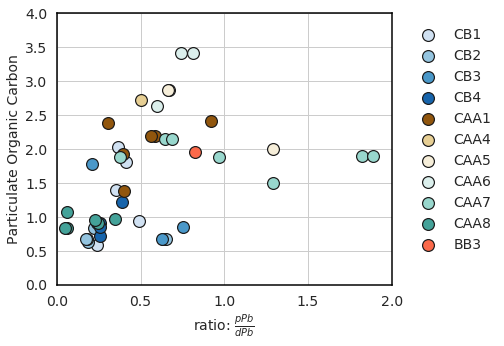

In [70]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    sns.scatterplot(ratio_CB1_m, POC_CB1_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(ratio_CB2_m, POC_CB2_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(ratio_CB3_m, POC_CB3_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(ratio_CB4_m, POC_CB4_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(ratio_CAA1_m, POC_CAA1_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(ratio_CAA3_m, POC_CAA3_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(ratio_CAA4_m, POC_CAA4_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(ratio_CAA5_m, POC_CAA5_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(ratio_CAA6_m, POC_CAA6_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(ratio_CAA7_m, POC_CAA7_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(ratio_CAA8_m, POC_CAA8_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
        
    sns.scatterplot(ratio_BB3_m, POC_BB3_m, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Particulate Organic Carbon', fontsize=14)
    ax.set_xlabel(r'ratio: $\frac{pPb}{dPb}$', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,2])
    ax.set_ylim([0,4])
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

##### Scavenging relation alternative: Aluminium 

In [22]:
pAl_CB1, pAl_depth_CB1 = load_data('CB1', dissolved=False, particulate=False, aluminium=True)
pAl_CB2, pAl_depth_CB2 = load_data('CB2', dissolved=False, particulate=False, aluminium=True)
pAl_CB3, pAl_depth_CB3 = load_data('CB3', dissolved=False, particulate=False, aluminium=True)
pAl_CB4, pAl_depth_CB4 = load_data('CB4', dissolved=False, particulate=False, aluminium=True)

pAl_BB3, pAl_depth_BB3 = load_data('BB3', dissolved=False, particulate=False, aluminium=True)

pAl_CAA1, pAl_depth_CAA1 = load_data('CAA1', dissolved=False, particulate=False, aluminium=True)
pAl_CAA3, pAl_depth_CAA3 = load_data('CAA3', dissolved=False, particulate=False, aluminium=True)
pAl_CAA4, pAl_depth_CAA4 = load_data('CAA4', dissolved=False, particulate=False, aluminium=True)
pAl_CAA5, pAl_depth_CAA5 = load_data('CAA5', dissolved=False, particulate=False, aluminium=True)
pAl_CAA6, pAl_depth_CAA6 = load_data('CAA6', dissolved=False, particulate=False, aluminium=True)
pAl_CAA7, pAl_depth_CAA7 = load_data('CAA7', dissolved=False, particulate=False, aluminium=True)
pAl_CAA8, pAl_depth_CAA8 = load_data('CAA8', dissolved=False, particulate=False, aluminium=True)
pAl_CAA9, pAl_depth_CAA9 = load_data('CAA9', dissolved=False, particulate=False, aluminium=True)

In [23]:
dPb_CB1_md, pAl_CB1_md, ddepths_CB1_md, Aldepths_CB1_md = pair_samples(dPb_CB1_use, pAl_CB1, ddepth_CB1, pAl_depth_CB1)
dPb_CB2_md, pAl_CB2_md, ddepths_CB2_md, Aldepths_CB2_md = pair_samples(dPb_CB2_use, pAl_CB2, ddepth_CB2, pAl_depth_CB2)
dPb_CB3_md, pAl_CB3_md, ddepths_CB3_md, Aldepths_CB3_md = pair_samples(dPb_CB3_use, pAl_CB3, ddepth_CB3, pAl_depth_CB3)
dPb_CB4_md, pAl_CB4_md, ddepths_CB4_md, Aldepths_CB4_md = pair_samples(dPb_CB4_use, pAl_CB4, ddepth_CB4, pAl_depth_CB4)
dPb_BB3_md, pAl_BB3_md, ddepths_BB3_md, Aldepths_BB3_md = pair_samples(dPb_BB3_use, pAl_BB3, ddepth_BB3, pAl_depth_BB3)

dPb_CAA1_md, pAl_CAA1_md, ddepths_CAA1_md, Aldepths_CAA1_md = pair_samples(dPb_CAA1_use, pAl_CAA1, ddepth_CAA1, pAl_depth_CAA1)
dPb_CAA3_md, pAl_CAA3_md, ddepths_CAA3_md, Aldepths_CAA3_md = pair_samples(dPb_CAA3_use, pAl_CAA3, ddepth_CAA3, pAl_depth_CAA3)
dPb_CAA4_md, pAl_CAA4_md, ddepths_CAA4_md, Aldepths_CAA4_md = pair_samples(dPb_CAA4_use, pAl_CAA4, ddepth_CAA4, pAl_depth_CAA4)
dPb_CAA5_md, pAl_CAA5_md, ddepths_CAA5_md, Aldepths_CAA5_md = pair_samples(dPb_CAA5_use, pAl_CAA5, ddepth_CAA5, pAl_depth_CAA5)
dPb_CAA6_md, pAl_CAA6_md, ddepths_CAA6_md, Aldepths_CAA6_md = pair_samples(dPb_CAA6_use, pAl_CAA6, ddepth_CAA6, pAl_depth_CAA6)
dPb_CAA7_md, pAl_CAA7_md, ddepths_CAA7_md, Aldepths_CAA7_md = pair_samples(dPb_CAA7_use, pAl_CAA7, ddepth_CAA7, pAl_depth_CAA7)
dPb_CAA8_md, pAl_CAA8_md, ddepths_CAA8_md, Aldepths_CAA8_md = pair_samples(dPb_CAA8_use, pAl_CAA8, ddepth_CAA8, pAl_depth_CAA8)

In [24]:
pPb_CB1_mp, pAl_CB1_mp, pdepths_CB1_mp, Aldepths_CB1_mp = pair_samples(pPb_CB1_use, pAl_CB1, pdepth_CB1, pAl_depth_CB1)
pPb_CB2_mp, pAl_CB2_mp, pdepths_CB2_mp, Aldepths_CB2_mp = pair_samples(pPb_CB2_use, pAl_CB2, pdepth_CB2, pAl_depth_CB2)
pPb_CB3_mp, pAl_CB3_mp, pdepths_CB3_mp, Aldepths_CB3_mp = pair_samples(pPb_CB3_use, pAl_CB3, pdepth_CB3, pAl_depth_CB3)
pPb_CB4_mp, pAl_CB4_mp, pdepths_CB4_mp, Aldepths_CB4_mp = pair_samples(pPb_CB4_use, pAl_CB4, pdepth_CB4, pAl_depth_CB4)
pPb_BB3_mp, pAl_BB3_mp, pdepths_BB3_mp, Aldepths_BB3_mp = pair_samples(pPb_BB3_use, pAl_BB3, pdepth_BB3, pAl_depth_BB3)

pPb_CAA1_mp, pAl_CAA1_mp, pdepths_CAA1_mp, Aldepths_CAA1_mp = pair_samples(pPb_CAA1_use, pAl_CAA1, pdepth_CAA1, pAl_depth_CAA1)
pPb_CAA3_mp, pAl_CAA3_mp, pdepths_CAA3_mp, Aldepths_CAA3_mp = pair_samples(pPb_CAA3_use, pAl_CAA3, pdepth_CAA3, pAl_depth_CAA3)
pPb_CAA4_mp, pAl_CAA4_mp, pdepths_CAA4_mp, Aldepths_CAA4_mp = pair_samples(pPb_CAA4_use, pAl_CAA4, pdepth_CAA4, pAl_depth_CAA4)
pPb_CAA5_mp, pAl_CAA5_mp, pdepths_CAA5_mp, Aldepths_CAA5_mp = pair_samples(pPb_CAA5_use, pAl_CAA5, pdepth_CAA5, pAl_depth_CAA5)
pPb_CAA6_mp, pAl_CAA6_mp, pdepths_CAA6_mp, Aldepths_CAA6_mp = pair_samples(pPb_CAA6_use, pAl_CAA6, pdepth_CAA6, pAl_depth_CAA6)
pPb_CAA7_mp, pAl_CAA7_mp, pdepths_CAA7_mp, Aldepths_CAA7_mp = pair_samples(pPb_CAA7_use, pAl_CAA7, pdepth_CAA7, pAl_depth_CAA7)
pPb_CAA8_mp, pAl_CAA8_mp, pdepths_CAA8_mp, Aldepths_CAA8_mp = pair_samples(pPb_CAA8_use, pAl_CAA8, pdepth_CAA8, pAl_depth_CAA8)

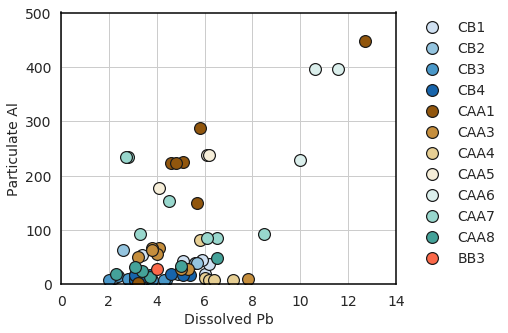

In [26]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    sns.scatterplot(dPb_CB1_md, pAl_CB1_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(dPb_CB2_md, pAl_CB2_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(dPb_CB3_md, pAl_CB3_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(dPb_CB4_md, pAl_CB4_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(dPb_CAA1_md, pAl_CAA1_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(dPb_CAA3_md, pAl_CAA3_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(dPb_CAA4_md, pAl_CAA4_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(dPb_CAA5_md, pAl_CAA5_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(dPb_CAA6_md, pAl_CAA6_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(dPb_CAA7_md, pAl_CAA7_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(dPb_CAA8_md, pAl_CAA8_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
        
    sns.scatterplot(dPb_BB3_md, pAl_BB3_md, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.05), fontsize=14, frameon=False)
    ax.set_ylabel('Particulate Al', fontsize=14)
    ax.set_xlabel('Dissolved Pb', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,14])
    ax.set_ylim([0,500])
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

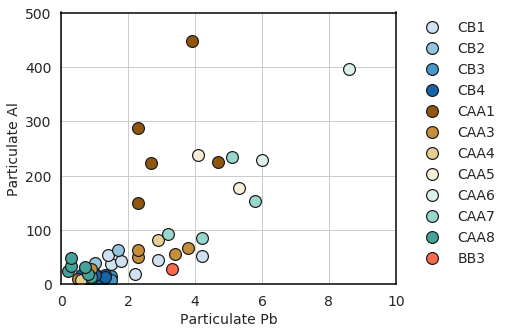

In [27]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    sns.scatterplot(pPb_CB1_mp, pAl_CB1_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(pPb_CB2_mp, pAl_CB2_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(pPb_CB3_mp, pAl_CB3_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(pPb_CB4_mp, pAl_CB4_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(pPb_CAA1_mp, pAl_CAA1_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(pPb_CAA3_mp, pAl_CAA3_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(pPb_CAA4_mp, pAl_CAA4_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(pPb_CAA5_mp, pAl_CAA5_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(pPb_CAA6_mp, pAl_CAA6_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(pPb_CAA7_mp, pAl_CAA7_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(pPb_CAA8_mp, pAl_CAA8_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
        
    sns.scatterplot(pPb_BB3_mp, pAl_BB3_mp, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.05), fontsize=14, frameon=False)
    ax.set_ylabel('Particulate Al', fontsize=14)
    ax.set_xlabel('Particulate Pb', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,10])
    ax.set_ylim([0,500])
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

In [25]:
ratio_CB1_Al, pAl_CB1_Al, ddepths_CB1_Al, pAldepths_CB1_Al = pair_samples(ratio_CB1, pAl_CB1, ddepths_CB1_mch, pAl_depth_CB1)
ratio_CB2_Al, pAl_CB2_Al, ddepths_CB2_Al, pAldepths_CB2_Al = pair_samples(ratio_CB2, pAl_CB2, ddepths_CB2_mch, pAl_depth_CB2)
ratio_CB3_Al, pAl_CB3_Al, ddepths_CB3_Al, pAldepths_CB3_Al = pair_samples(ratio_CB3, pAl_CB3, ddepths_CB3_mch, pAl_depth_CB3)
ratio_CB4_Al, pAl_CB4_Al, ddepths_CB4_Al, pAldepths_CB4_Al = pair_samples(ratio_CB4, pAl_CB4, ddepths_CB4_mch, pAl_depth_CB4)
ratio_BB3_Al, pAl_BB3_Al, ddepths_BB3_Al, pAldepths_BB3_Al = pair_samples(ratio_BB3, pAl_BB3, ddepths_BB3_mch, pAl_depth_BB3)

ratio_CAA1_Al, pAl_CAA1_Al, ddepths_CAA1_Al, pAldepths_CAA1_Al = pair_samples(ratio_CAA1, pAl_CAA1, ddepths_CAA1_mch, pAl_depth_CAA1)
ratio_CAA3_Al, pAl_CAA3_Al, ddepths_CAA3_Al, pAldepths_CAA3_Al = pair_samples(ratio_CAA3, pAl_CAA3, ddepths_CAA3_mch, pAl_depth_CAA3)
ratio_CAA4_Al, pAl_CAA4_Al, ddepths_CAA4_Al, pAldepths_CAA4_Al = pair_samples(ratio_CAA4, pAl_CAA4, ddepths_CAA4_mch, pAl_depth_CAA4)
ratio_CAA5_Al, pAl_CAA5_Al, ddepths_CAA5_Al, pAldepths_CAA5_Al = pair_samples(ratio_CAA5, pAl_CAA5, ddepths_CAA5_mch, pAl_depth_CAA5)
ratio_CAA6_Al, pAl_CAA6_Al, ddepths_CAA6_Al, pAldepths_CAA6_Al = pair_samples(ratio_CAA6, pAl_CAA6, ddepths_CAA6_mch, pAl_depth_CAA6)
ratio_CAA7_Al, pAl_CAA7_Al, ddepths_CAA7_Al, pAldepths_CAA7_Al = pair_samples(ratio_CAA7, pAl_CAA7, ddepths_CAA7_mch, pAl_depth_CAA7)
ratio_CAA8_Al, pAl_CAA8_Al, ddepths_CAA8_Al, pAldepths_CAA8_Al = pair_samples(ratio_CAA8, pAl_CAA8, ddepths_CAA8_mch, pAl_depth_CAA8)

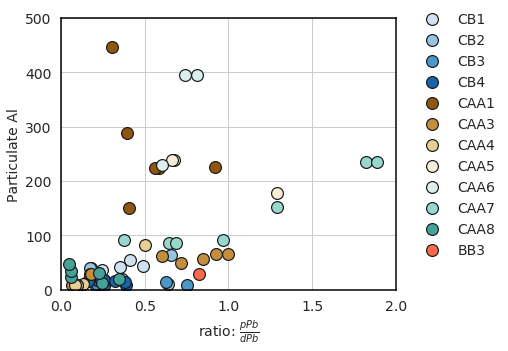

In [78]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    sns.scatterplot(ratio_CB1_Al, pAl_CB1_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(ratio_CB2_Al, pAl_CB2_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(ratio_CB3_Al, pAl_CB3_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(ratio_CB4_Al, pAl_CB4_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(ratio_CAA1_Al, pAl_CAA1_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(ratio_CAA3_Al, pAl_CAA3_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(ratio_CAA4_Al, pAl_CAA4_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(ratio_CAA5_Al, pAl_CAA5_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(ratio_CAA6_Al, pAl_CAA6_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(ratio_CAA7_Al, pAl_CAA7_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(ratio_CAA8_Al, pAl_CAA8_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
        
    sns.scatterplot(ratio_BB3_Al, pAl_BB3_Al, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Particulate Al', fontsize=14)
    ax.set_xlabel(r'ratio: $\frac{pPb}{dPb}$', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,2])
    ax.set_ylim([0,500])
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

##### Fit based on POC and pAl:

$$ \frac{pPb}{dPb} = a_{1}\cdot POC + a_{2} \cdot pAl$$

find: $a_1$ and $a_2$

In [26]:
ratio_stns = np.concatenate([ratio_CB1_m, ratio_CB2_m, ratio_CB3_m, ratio_CB4_m, ratio_BB3_m, ratio_CAA1_m, \
                             ratio_CAA3_m, ratio_CAA4_m, ratio_CAA5_m, ratio_CAA6_m, ratio_CAA7_m, ratio_CAA8_m])

POC_stns   = np.concatenate([POC_CB1_m, POC_CB2_m, POC_CB3_m, POC_CB4_m, POC_BB3_m, POC_CAA1_m, \
                             POC_CAA3_m, POC_CAA4_m, POC_CAA5_m, POC_CAA6_m, POC_CAA7_m, POC_CAA8_m])

In [27]:
pAl_stns   = np.concatenate([pAl_CB1_Al, pAl_CB2_Al, pAl_CB3_Al, pAl_CB4_Al, pAl_BB3_Al, pAl_CAA1_Al, \
                             pAl_CAA3_Al, pAl_CAA4_Al, pAl_CAA5_Al, pAl_CAA6_Al, pAl_CAA7_Al, pAl_CAA8_Al])

In [29]:
def func(X, a, b):
    x,y = X
    return a*x + b*y

In [35]:
ratio_stns_nonan = []
POC_stns_nonan   = []
pAl_stns_nonan   = []

for i in range(0,len(ratio_stns)):
    if np.isnan(ratio_stns[i]) or np.isnan(POC_stns[i]) or np.isnan(pAl_stns[i]):
        pass
    else:
        ratio_stns_nonan.append(ratio_stns[i])
        POC_stns_nonan.append(POC_stns[i])
        pAl_stns_nonan.append(pAl_stns[i])

In [53]:
# initial guesses for a,b:
p0 = 0.8, 0.2 
popt, pcov = curve_fit(func, (POC_stns_nonan, pAl_stns_nonan), ratio_stns_nonan, p0)
perr = np.sqrt(np.diag(pcov))

In [51]:
pAl = np.linspace(0,450,150)
POC = np.linspace(0,16,150)

ratio_model = popt[0]*POC + popt[1]*pAl

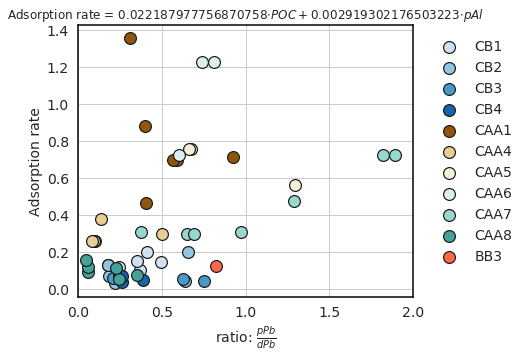

In [54]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    a1 = popt[0]
    a2 = popt[1]
    
    sns.scatterplot(ratio_CB1_m, a1*POC_CB1_m + a2*pAl_CB1_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(ratio_CB2_m, a1*POC_CB2_m + a2*pAl_CB2_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(ratio_CB3_m, a1*POC_CB3_m + a2*pAl_CB3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(ratio_CB4_m, a1*POC_CB4_m + a2*pAl_CB4_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(ratio_CAA1_m, a1*POC_CAA1_m + a2*pAl_CAA1_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(ratio_CAA3_m, a1*POC_CAA3_m + a2*pAl_CAA3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(ratio_CAA4_m, a1*POC_CAA4_m + a2*pAl_CAA4_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(ratio_CAA5_m, a1*POC_CAA5_m + a2*pAl_CAA5_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(ratio_CAA6_m, a1*POC_CAA6_m + a2*pAl_CAA6_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(ratio_CAA7_m, a1*POC_CAA7_m + a2*pAl_CAA7_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(ratio_CAA8_m, a1*POC_CAA8_m + a2*pAl_CAA8_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
        
    sns.scatterplot(ratio_BB3_m, a1*POC_BB3_m + a2*pAl_BB3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Adsorption rate', fontsize=14)
    ax.set_xlabel(r'ratio: $\frac{pPb}{dPb}$', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,2])
#     ax.set_ylim([0,4])
    ax.set_title('Adsorption rate = '+str(a1)+r'$\cdot POC + $'+str(a2)+r'$\cdot pAl$')
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

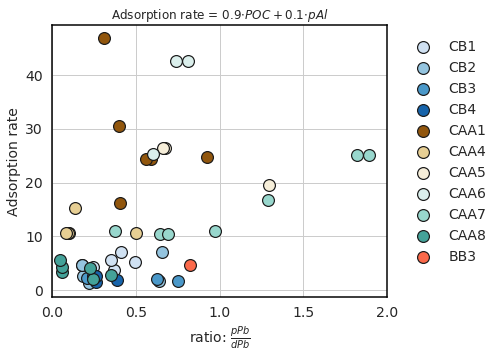

In [99]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    a1 = 0.9
    a2 = 0.1
    
    sns.scatterplot(ratio_CB1_m, a1*POC_CB1_m + a2*pAl_CB1_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label='CB1')
    sns.scatterplot(ratio_CB2_m, a1*POC_CB2_m + a2*pAl_CB2_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label='CB2')
    sns.scatterplot(ratio_CB3_m, a1*POC_CB3_m + a2*pAl_CB3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label='CB3')
    sns.scatterplot(ratio_CB4_m, a1*POC_CB4_m + a2*pAl_CB4_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label='CB4')
    
    sns.scatterplot(ratio_CAA1_m, a1*POC_CAA1_m + a2*pAl_CAA1_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label='CAA1')
    sns.scatterplot(ratio_CAA3_m, a1*POC_CAA3_m + a2*pAl_CAA3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label='CAA3')
    sns.scatterplot(ratio_CAA4_m, a1*POC_CAA4_m + a2*pAl_CAA4_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label='CAA4')
    sns.scatterplot(ratio_CAA5_m, a1*POC_CAA5_m + a2*pAl_CAA5_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label='CAA5')
    sns.scatterplot(ratio_CAA6_m, a1*POC_CAA6_m + a2*pAl_CAA6_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label='CAA6')
    sns.scatterplot(ratio_CAA7_m, a1*POC_CAA7_m + a2*pAl_CAA7_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label='CAA7')
    sns.scatterplot(ratio_CAA8_m, a1*POC_CAA8_m + a2*pAl_CAA8_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label='CAA8')
        
    sns.scatterplot(ratio_BB3_m, a1*POC_BB3_m + a2*pAl_BB3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label='BB3')

    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Adsorption rate', fontsize=14)
    ax.set_xlabel(r'ratio: $\frac{pPb}{dPb}$', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,2])
#     ax.set_ylim([0,4])
    ax.set_title('Adsorption rate = '+str(a1)+r'$\cdot POC + $'+str(a2)+r'$\cdot pAl$')
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

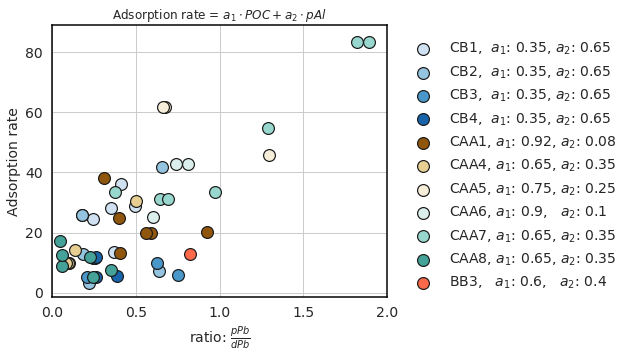

In [162]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    a1 = 0.35 #0.7
    a2 = 0.65 #0.3
    sns.scatterplot(ratio_CB1_m, a1*POC_CB1_m + a2*pAl_CB1_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[0], label=r'CB1,  $a_1$: '+str(a1)+r', $a_2$: '+str(a2))
    sns.scatterplot(ratio_CB2_m, a1*POC_CB2_m + a2*pAl_CB2_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[1], label=r'CB2,  $a_1$: '+str(a1)+r', $a_2$: '+str(a2))
    sns.scatterplot(ratio_CB3_m, a1*POC_CB3_m + a2*pAl_CB3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[2], label=r'CB3,  $a_1$: '+str(a1)+r', $a_2$: '+str(a2))
    sns.scatterplot(ratio_CB4_m, a1*POC_CB4_m + a2*pAl_CB4_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[3], label=r'CB4,  $a_1$: '+str(a1)+r', $a_2$: '+str(a2))
    
    a1=0.65
    a2=0.35
    sns.scatterplot(ratio_CAA1_m, 0.92*POC_CAA1_m + 0.08*pAl_CAA1_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[4], label=r'CAA1, $a_1$: '+str(0.92)+r', $a_2$: '+str(0.08))
    sns.scatterplot(ratio_CAA3_m, a1*POC_CAA3_m + a2*pAl_CAA3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[5], label=r'CAA3, $a_1$: '+str(a1)+r', $a_2$: '+str(a2))
    sns.scatterplot(ratio_CAA4_m, a1*POC_CAA4_m + a2*pAl_CAA4_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[6], label=r'CAA4, $a_1$: '+str(a1)+r', $a_2$: '+str(a2))
    sns.scatterplot(ratio_CAA5_m, 0.75*POC_CAA5_m + 0.25*pAl_CAA5_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[7], label=r'CAA5, $a_1$: '+str(0.75)+r', $a_2$: '+str(0.25))
    sns.scatterplot(ratio_CAA6_m, 0.9*POC_CAA6_m + 0.1*pAl_CAA6_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[8], label=r'CAA6, $a_1$: '+str(0.90)+r',   $a_2$: '+str(0.10))
    sns.scatterplot(ratio_CAA7_m, a1*POC_CAA7_m + a2*pAl_CAA7_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[9], label=r'CAA7, $a_1$: '+str(a1)+r', $a_2$: '+str(a2))
    sns.scatterplot(ratio_CAA8_m, a1*POC_CAA8_m + a2*pAl_CAA8_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[10], label=r'CAA8, $a_1$: '+str(a1)+r', $a_2$: '+str(a2))
    
    a1=0.6    
    a2=0.4
    sns.scatterplot(ratio_BB3_m, a1*POC_BB3_m + a2*pAl_BB3_Al, \
                    s=140, edgecolor='k', linewidth=1.2, color=stn_colors[12], label=r'BB3,   $a_1$: '+str(a1)+r',   $a_2$: '+str(a2))

    ax.legend(loc=(1.05, 0.0), fontsize=14, frameon=False)
    ax.set_ylabel('Adsorption rate', fontsize=14)
    ax.set_xlabel(r'ratio: $\frac{pPb}{dPb}$', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([0,2])
    ax.set_title(r'Adsorption rate = $a_1 \cdot POC + a_2 \cdot pAl$')
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    